In [1]:
#SQLAlchemy imports
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [2]:
#Pandas and Matplotlib imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

Inspecting database

In [4]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Use Inspector to print the column names and types for 'measurement' table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
measure_rows = engine.execute('SELECT * FROM ' '"measurement"' 'LIMIT 0,9').fetchall()

for row in measure_rows:
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)


In [7]:
# Use Inspector to print the column names and types for 'station' table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
station_rows = engine.execute('SELECT * FROM ' '"station"' 'LIMIT 0,15').fetchall()

for row in station_rows:
    print(row)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


#### Reflect Tables into SQLAlchemy ORM

In [9]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

In [10]:
M = Base.classes.measurement
S = Base.classes.station

In [11]:
# Start a session to query the database
session = Session(engine)

## Precipitation Analysis

In [12]:
data = engine.execute('SELECT MAX(date) FROM ' '"measurement"' '').fetchall() #Get last date in table
last_date_str = data[0][0]

In [13]:
# Method 2
# test = session.query(Measurement.station, func.max(Measurement.date))
# for t in test:
#     last_date = t[0]

# Method 3
# test = session.query(Measurement.station, func.max(Measurement.date)).all()
# test

In [14]:
last_date_frmt = datetime.strptime(last_date_str, '%Y-%m-%d').date() #Convert datestring to datetime
from dateutil.relativedelta import relativedelta
date_1_year_ago = last_date_frmt - relativedelta(years=1)

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(M.date, M.prcp).order_by(M.date.asc()).filter(M.date >= date_1_year_ago)

dates = [result[0] for result in results[:]]
prcps = [result[1] for result in results[:]]

In [16]:
# Store values in a dataframe
df1 = pd.DataFrame(results[:], columns=['Date', 'Precipitation'])
df1.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [17]:
# Converting Date column to datetime type
df1['Date'] =  pd.to_datetime(df1['Date'])
df1.dtypes

Date             datetime64[ns]
Precipitation           float64
dtype: object

In [18]:
#Number of rows in dataframe presently
df1.shape[0]

2230

In [19]:
df1 = df1.dropna()

In [20]:
#Number of rows in dataframe presently
df1.shape[0]

2021

In [21]:
df1.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


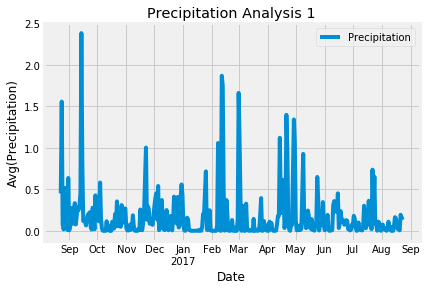

In [22]:
df1_grouped = df1.groupby(['Date'], as_index=True).mean()
ax = df1_grouped.plot()
ax.set(xlabel='Date', ylabel='Avg(Precipitation)', title ='Precipitation Analysis 1')
plt.show()

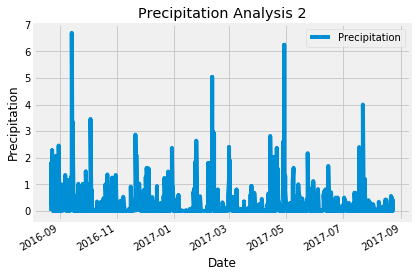

In [23]:
ax = df1.plot(x='Date', y='Precipitation')
ax.set(xlabel='Date', ylabel='Precipitation', title ='Precipitation Analysis 2')
plt.show()

## Station Analysis

In [24]:
# Design a query to show how many stations are available in this dataset?

num_stations = session.query(S.station).group_by(S.station).count()
print(f'Number of stations in the dataset: {num_stations}')

Number of stations in the dataset: 9


In [25]:
# Print all the unique station names

qry = session.query(S.station.distinct().label("stations"))
stations = [row.stations for row in qry.all()]
stations

['USC00519397',
 'USC00513117',
 'USC00514830',
 'USC00517948',
 'USC00518838',
 'USC00519523',
 'USC00519281',
 'USC00511918',
 'USC00516128']

In [26]:
#List the stations and observation counts in descending order.

station_counts = session.query(M.station, func.count(M.tobs)).group_by(M.station).order_by(func.count(M.station).desc())

for i in station_counts:
    print(f'Station {i[0]} recorded {i[1]} observations')

Station USC00519281 recorded 2772 observations
Station USC00519397 recorded 2724 observations
Station USC00513117 recorded 2709 observations
Station USC00519523 recorded 2669 observations
Station USC00516128 recorded 2612 observations
Station USC00514830 recorded 2202 observations
Station USC00511918 recorded 1979 observations
Station USC00517948 recorded 1372 observations
Station USC00518838 recorded 511 observations


In [27]:
# Which station has the highest number of observations?
station_max_obs = session.query(M.station, func.count(M.station)).group_by(M.station).\
                    order_by(func.count(M.station).desc()).first()

print(f'The station with highest number of observations is {station_max_obs[0]}')

The station with highest number of observations is USC00519281


In [28]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
results = session.query(M.date, M.tobs).order_by(M.date.asc()).filter(M.station == station_max_obs[0]).\
        filter((M.date >= date_1_year_ago))

dates = [result[0] for result in results[:]]
temps = [result[1] for result in results[:]]

In [29]:
# Store values in a dataframe
df2 = pd.DataFrame(results[:], columns=['Date', 'Temperature'])
df2.head()

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


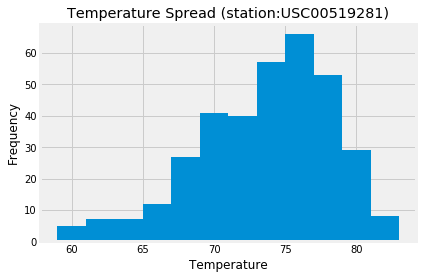

In [30]:
ax = df2.hist(column='Temperature', bins =12, label = 'Temo')
plt.title("Temperature Spread (station:USC00519281)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [31]:
results = session.query(M.date, M.tobs).order_by(M.date.asc()).filter(M.station == station_max_obs[0]).\
        filter((M.date >= date_1_year_ago))
for row in results:
    print(row)

('2016-08-23', 77.0)
('2016-08-24', 77.0)
('2016-08-25', 80.0)
('2016-08-26', 80.0)
('2016-08-27', 75.0)
('2016-08-28', 73.0)
('2016-08-29', 78.0)
('2016-08-30', 77.0)
('2016-08-31', 78.0)
('2016-09-01', 80.0)
('2016-09-02', 80.0)
('2016-09-03', 78.0)
('2016-09-04', 78.0)
('2016-09-05', 78.0)
('2016-09-06', 73.0)
('2016-09-07', 74.0)
('2016-09-08', 80.0)
('2016-09-09', 79.0)
('2016-09-10', 77.0)
('2016-09-11', 80.0)
('2016-09-12', 76.0)
('2016-09-13', 79.0)
('2016-09-14', 75.0)
('2016-09-15', 79.0)
('2016-09-16', 78.0)
('2016-09-17', 79.0)
('2016-09-18', 78.0)
('2016-09-19', 78.0)
('2016-09-20', 76.0)
('2016-09-21', 74.0)
('2016-09-22', 77.0)
('2016-09-23', 78.0)
('2016-09-24', 79.0)
('2016-09-25', 79.0)
('2016-09-26', 77.0)
('2016-09-27', 80.0)
('2016-09-28', 78.0)
('2016-09-29', 78.0)
('2016-09-30', 78.0)
('2016-10-01', 77.0)
('2016-10-02', 79.0)
('2016-10-03', 79.0)
('2016-10-04', 79.0)
('2016-10-05', 79.0)
('2016-10-06', 75.0)
('2016-10-07', 76.0)
('2016-10-08', 73.0)
('2016-10-09'